In [1]:
import lightgbm as lgb
from sklearn import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

In [2]:
if 'ygong' in os.getcwd():
    filepath = "../data"
    dir_out = "../output"
else:
    filepath = "/home/gong/Documents/Kaggle_July2019/data"
    dir_out = "/home/gong/Documents/Kaggle_July2019/output"

In [3]:
data = pd.read_csv(os.path.join(dir_out, '_train.csv'))
data_submit = pd.read_csv(os.path.join(dir_out, '_test.csv'))
print('Train dataset shape is now rows: {} cols:{}'.format(data.shape[0], data.shape[1]))
X = data.drop(columns=['scalar_coupling_constant'])
y = data['scalar_coupling_constant']
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Train dataset shape is now rows: 4658147 cols:22


In [4]:
train_0730 = pd.read_csv(os.path.join(dir_out, '_train_0730.csv'))
test_0730 = pd.read_csv(os.path.join(dir_out, '_test_0730.csv'))

In [5]:
train_0730.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,n_bonds,type_bond,cov,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,dist
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,1,HC,1,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001,1.091953
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,2,HH,0,H,0.002150,-0.006031,0.001976,H,1.011731,1.463751,0.000277,1.783120
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,2,HH,0,H,0.002150,-0.006031,0.001976,H,-0.540815,1.447527,-0.876644,1.783147
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,2,HH,0,H,0.002150,-0.006031,0.001976,H,-0.523814,1.437933,0.906397,1.783157
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,1,HC,1,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001,1.091952


In [8]:
X['n_bonds'] = train_0730['n_bonds']
X['dist'] = train_0730['dist']
X['cov'] = train_0730['cov']
data_submit['n_bonds'] = test_0730['n_bonds']
data_submit['dist'] = test_0730['dist']
data_submit['cov'] = test_0730['cov']

In [14]:
train = X.copy()
train['scalar_coupling_constant'] = y
train.to_csv(os.path.join(dir_out, '_train0731.csv'))
data_submit.to_csv(os.path.join(dir_out, '_test0731.csv'))

In [10]:
# cross-validation
params = {'num_leaves': 50, 
          'min_child_samples': 79,
          'min_data_in_leaf': 100,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0,
         }

reg_model = lgb.LGBMRegressor(**params)
scores = []
cv = KFold(n_splits=10, random_state=42)
for train_index, test_index in cv.split(X):
    print("Train Index: ", train_index)
    print("Test Index: ", test_index, "\n")

    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
    reg_model.fit(X_train, y_train)
    scores.append(reg_model.score(X_test, y_test))
print('scores: \n {}'.format(scores))

Train Index:  [ 465815  465816  465817 ... 4658144 4658145 4658146]
Test Index:  [     0      1      2 ... 465812 465813 465814] 

Train Index:  [      0       1       2 ... 4658144 4658145 4658146]
Test Index:  [465815 465816 465817 ... 931627 931628 931629] 

Train Index:  [      0       1       2 ... 4658144 4658145 4658146]
Test Index:  [ 931630  931631  931632 ... 1397442 1397443 1397444] 

Train Index:  [      0       1       2 ... 4658144 4658145 4658146]
Test Index:  [1397445 1397446 1397447 ... 1863257 1863258 1863259] 

Train Index:  [      0       1       2 ... 4658144 4658145 4658146]
Test Index:  [1863260 1863261 1863262 ... 2329072 2329073 2329074] 

Train Index:  [      0       1       2 ... 4658144 4658145 4658146]
Test Index:  [2329075 2329076 2329077 ... 2794887 2794888 2794889] 

Train Index:  [      0       1       2 ... 4658144 4658145 4658146]
Test Index:  [2794890 2794891 2794892 ... 3260702 3260703 3260704] 

Train Index:  [      0       1       2 ... 4658144 46

Train score: 0.9950148680738179
Test score: 0.9955865366241233


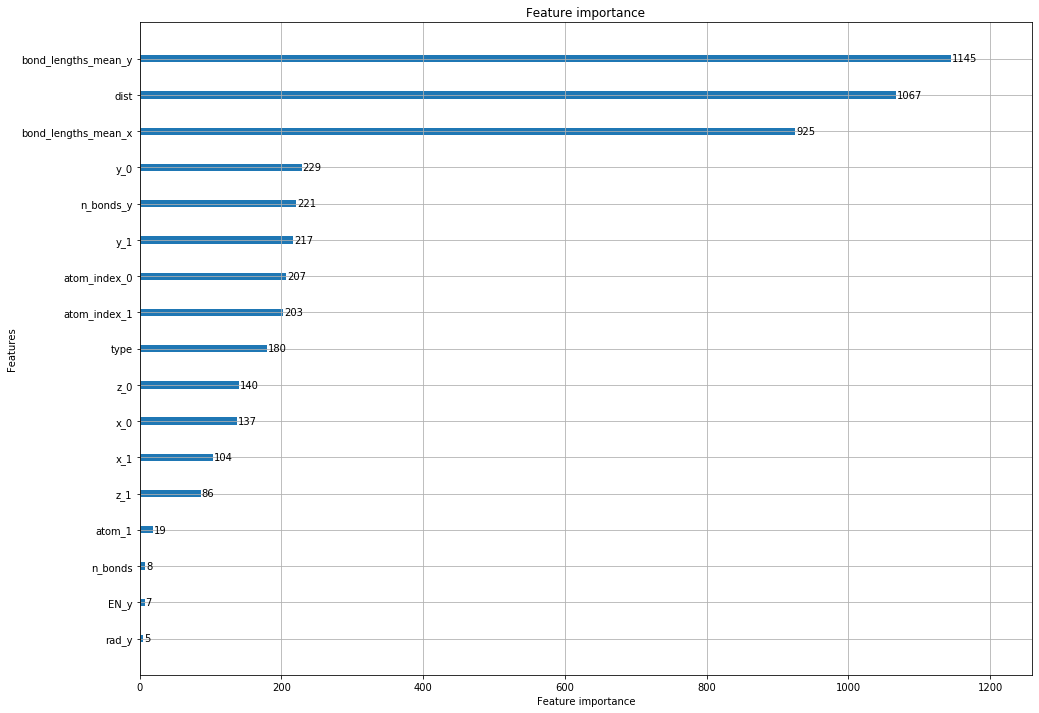

The mean absolute deviation is 0.4668750741882761


In [11]:
y_predict = reg_model.predict(X_test)
print('Train score: {}'.format(reg_model.score(X_train, y_train)))
print('Test score: {}'.format(reg_model.score(X_test, y_test)))

fig, axes = plt.subplots()
fig.set_size_inches(16, 12)
lgb.plot_importance(reg_model, ax=axes)
plt.show()

# print MAE
error = mean_absolute_error(y_test, y_predict)
print('The mean absolute deviation is {}'.format(np.log(error)))

In [12]:
y_predict_lgb = reg_model.predict(data_submit)
submit = pd.read_csv(os.path.join(filepath, 'sample_submission.csv')).drop(columns='scalar_coupling_constant')
submit['scalar_coupling_constant'] = y_predict_lgb
submit.to_csv(os.path.join(dir_out, 'submission.csv'), index=False)

In [13]:
import subprocess
#subprocess.check_output(['ls','-l']) #all that is technically needed...
print(subprocess.check_output(['pwd']))
subprocess.call(['sh', './submit.sh'])

b'/home/gong/Documents/Kaggle_July2019/code\n'


1